# RAPPOR – Server-side

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

Disabling scientific notation makes it a bit easier to compare numeric values with the ones logged in the R part:

In [2]:
np.set_printoptions(suppress=True)

## Reading the data files

In production, the content of these files is coming from the clients. For testing, we just use files that are generated by Google's simulations.

In [3]:
base = "../rappor/"
base += "_tmp/python/r-gauss-small-sim_bloom_filter1_1/"

PARAMS_PATH = base + "case_params.csv"
COUNTS_PATH = base + "1/case_counts.csv"
MAP_PATH = base + "case_map.csv"
CANDIDATES_PATH = base + "case_unique_values.txt" #"case_candidates.txt"

### params

In [4]:
k, h, m, p, q, f = pd.read_csv(PARAMS_PATH).iloc[0]
k = int(k)
h = int(h)
m = int(m)

In [5]:
print "- The Bloom filter has k=%d bits and uses h=%d hash functions" % (k, h)
print "- There are m=%d cohorts" % m
print "- There is a f=%.2f probability of randomly changing a bit for the PRR" % f
print "- There is a p=%.2f (q=%.2f) probability of setting a bit in the IRR to 1 if that bit was 0 in the PRR" % (p, q)

- The Bloom filter has k=4 bits and uses h=2 hash functions
- There are m=32 cohorts
- There is a f=0.00 probability of randomly changing a bit for the PRR
- There is a p=0.50 (q=0.75) probability of setting a bit in the IRR to 1 if that bit was 0 in the PRR


### counts

Each row contains information about one cohort. The very first value in a row specifies the total number of reports in that cohort. The other values specify how often the respective bit was set in the sent Bloom Filter. Because some bits were randomly changed, the first value can be smaller or greater than the sum of the other values in that row.

Cohorts without any reports are directly removed.

In the real server implementation, we will need a little bit of additional logic for calculating these sums. Here, we just use what Google's implementation already provides.

In [6]:
counts = DataFrame.from_csv(COUNTS_PATH, header=None, index_col=None)
counts = counts[counts[0] != 0]
counts.head()

,0,1,2,3,4
0,31250,18176,19389,18710,19497
1,31250,18527,19047,19137,18602
2,31250,18500,18459,19104,19343
3,31250,17751,19476,18634,19038
4,31250,18890,19827,19512,18683


### map (hash values)

One row for every candidate string. The leftmost value in a row (Pandas' index) shows the respective string, the other values (number of cohorts * number of hash functions) show the hashed values of that string.

In [7]:
maps = DataFrame.from_csv(MAP_PATH, header=None)
maps.head()

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
0,,,,,,,,,,,,,,,,,,,,,
v1,2,4,6,7,12,9,15,15,20,17,...,112,109,114,115,119,120,123,121,127,126
v2,3,4,8,7,9,10,16,16,20,18,...,110,110,113,114,120,117,122,122,128,126
v3,2,1,6,5,10,12,16,16,19,19,...,110,109,113,115,120,119,122,123,128,127
v4,2,1,8,6,10,11,14,14,20,19,...,112,110,114,113,120,117,123,123,128,127
v5,1,3,5,7,12,11,16,13,19,19,...,112,111,116,114,120,118,121,122,126,127


### candidates

Here, the candidates are simply the values that were also used by the client-side code. Generally, we would like to use a superset of these values, e.g. the most popular websites.

In [8]:
def get_candidates():
    with open(CANDIDATES_PATH) as f:
        lines = f.readlines()
        return [candidate.strip() for candidate in lines]

In [9]:
candidates = get_candidates()

Just for testing, we'll try a superset:

In [10]:
candidates = ["v%d" % i for i in range(300)]

In [11]:
candidates[:10]

['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']

In [12]:
M = len(candidates)

## Preparing the data to separate signal and noise

The high-level task of the server-side is to find out which candidate strings were really used by the clients. We will use statistical techniques for doing this, namely linear regression to find out which candidate strings probably influenced the final result.

Another way to think about this: In Machine Learning and statistics we are often concerned with separating signal from noise. Here, the signal is given by the hashed values of candidate strings. The noise is added on purpose by clients in order to maintain privacy. On the server-side, we then try to use statistical techniques to remove the noise from the aggregated data.

### Target values $y$: Estimating true counts of the original Bloom filter

First of all, we do some basic preprocessing to be able to use the same variables that are also being used by the RAPPOR paper. This makes it a bit easier to implement the math formulas given in the paper.

$N$ is a vector containing the number of reports from the individual cohorts. $c$ is a matrix
where $c_{ij}$ tells us how often bit $j$ was set in cohort $i$.

In [13]:
N = counts[0].as_matrix()
c = counts.drop([0], axis=1).as_matrix().T

The target values $y$ will contain estimates of how often the individual bits were really set in the original bloom filter.

$$
t_{ij} = \frac{c_{ij} - (p + 0.5fq - 0.5fp) N_j}{(1 - f) (q - p)}
$$

$Y$ is then simply a long vector that contains the rows of $t$ flattened. `estimate_bloom_counts` calculates $y$ in a vectorized way.

**TODO**: Understand why this formula holds

In [14]:
def estimate_bloom_count(c, N):
    Y = c - ((p + 0.5 * f * q - 0.5 * f * p) * N)
    Y /= ((1 - f) * (q - p))
    return Y

In [15]:
Y = estimate_bloom_count(c, N)

In [16]:
print Y.shape
assert(Y.shape == (k, m))

(4, 32)


This is not mentioned in the paper, but actually $Y$ is then also divided by $N$ to get frequencies instead of counts. We also reshape the matrix to one long vector, and call this $y$.

In [17]:
y = (Y / N).T.reshape(k * m)

### Design matrix $X$:  Encoding the hashed values of candidates

$X$ has the shape $km \times M$ where
- $k$ is the number of bits in the Bloom filter
- $m$ is the number of cohorts
- $M$ is the number of candidate strings

Each candidate string corresponds to one feature. Each feature has $h * m$ values set to $1$, all others are $0$. This makes $X$ a sparse matrix.

Each data point corresponds to one bit in a cohort. A cell in that row is set to $1$ if that bit would be set by using the respective hashed candidate string.

---

To get the bits set in a Bloom filter, we import a function from Google's repo. This is important because we need to make sure to use the same hash function in client and server.

In [18]:
from client.rappor import get_bloom_bits

This function gives us the bits that are set when the candidate string is hashed:

In [19]:
get_bloom_bits("test", 4, h, k)

[3, 0]

Next, we can finally create $X$ by creating the matrices of the individual cohorts, and then stacking them vertically.

In [20]:
matrix = []

for cohort in range(m):
    rows = []
    
    for candidate in candidates:
        bits = np.zeros(k)
        bits_set = get_bloom_bits(candidate, cohort, h, k)
        bits[bits_set] = 1
        rows.append(bits)
        
    for row in np.array(rows).T:
        matrix.append(row)

X = np.array(matrix)

In [21]:
print X.shape
assert(X.shape == (k * m, M))

(128, 300)


To give some intuition on what we're doing here: The design matrix $X$ contains information about what bits would be set by which candidates. By using the estimated counts of the individual bits, we then try to infer which candidate strings really appeared.

**TODO**: Why do we use the estimated results, instead of the observed counts?

## Lasso: Eliminating some candidates

In the RAPPOR paper, Google says they fit a Lasso model and only continue working with candidate strings that have non-zero coefficients. This acts as a preliminary filter to make the next model simpler.

**TODO**: Understand how exactly this helps

However, actually, Google only performs this Lasso regression if the number of candidates $M$ is larger than $0.8 * m * k$, as this means the system is close to being underdetermined.

**TODO**: Understand why this exact condition exists

In [22]:
from sklearn.linear_model import Lasso

In [23]:
cut_off = 0.8 * m * k
perform_lasso = M > cut_off

print M, cut_off, "| Lasso should be performed:", perform_lasso

300 102.4 | Lasso should be performed: True


It seems like we can't use $y$ here.

In [24]:
clf = Lasso()
clf.fit(X, y)
clf.coef_

array([-0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0.,
       -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0.,  0.,  0., -0., -0., -0.,  0., -0., -0., -0.,  0.,  0.,  0.,
        0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,
       -0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,
        0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0., -0., -0.,  0.,  0., -0., -0.,  0., -0., -0., -0., -0.,
       -0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,  0.,
       -0.,  0.,  0., -0., -0., -0., -0., -0., -0.,  0., -0., -0

Instead, $Y$ is needed. Scaling the target values to larger values probably weakens the l1 penalty.

In [25]:
clf = Lasso()
clf.fit(X, Y.reshape(128))
clf.coef_

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([   -0.        ,    -0.        ,    -0.        ,    -0.        ,
        -158.48839076,    -0.        ,    -0.        ,    -0.        ,
         883.22681299,    -0.        ,     0.        ,     0.        ,
           0.        ,    56.76638169,  -161.49275698,  -212.66552663,
           0.        ,  -468.52744405,    -0.        ,     0.        ,
         710.43218257,    -0.        ,     0.        ,    -0.        ,
           0.        ,   210.64604412,    87.83443809,  1485.82263726,
        -969.60543633,   316.00682313,    72.38384404,    -0.        ,
          -0.        ,   219.9638582 ,    -0.        ,     0.        ,
           0.        ,  -233.13024682,    -0.        ,  -894.44822621,
          -0.        ,     0.        ,   596.84358   ,    -0.        ,
          27.28325282,    -0.        ,    -0.        ,   -32.28046818,
          -0.        ,  -612.51464747,    -0.        ,  -237.15146499,
        -660.1447172 ,  -399.55904226,   -71.18870424,     0.        ,
      

**TODO**: Figure out if this is really the proper way to do it. What we call `good_candidates` here doesn't have that much overlap with the results when not using Lasso.

In [26]:
good_candidates = np.where(clf.coef_ > 0)[0]
good_candidates

array([  8,  13,  20,  25,  26,  27,  29,  30,  33,  42,  44,  58,  61,
        66,  68,  69,  77,  80,  82,  91,  93,  94,  95, 107, 110, 116,
       117, 119, 129, 130, 132, 134, 138, 142, 144, 145, 153, 160, 165,
       168, 170, 174, 177, 180, 192, 197, 198, 200, 201, 203, 204, 205,
       209, 215, 216, 220, 223, 227, 234, 244, 261, 265, 267, 270, 274,
       276, 282, 290])

In [27]:
len(good_candidates)

68

In [28]:
[candidates[i] for i in good_candidates]

['v8',
 'v13',
 'v20',
 'v25',
 'v26',
 'v27',
 'v29',
 'v30',
 'v33',
 'v42',
 'v44',
 'v58',
 'v61',
 'v66',
 'v68',
 'v69',
 'v77',
 'v80',
 'v82',
 'v91',
 'v93',
 'v94',
 'v95',
 'v107',
 'v110',
 'v116',
 'v117',
 'v119',
 'v129',
 'v130',
 'v132',
 'v134',
 'v138',
 'v142',
 'v144',
 'v145',
 'v153',
 'v160',
 'v165',
 'v168',
 'v170',
 'v174',
 'v177',
 'v180',
 'v192',
 'v197',
 'v198',
 'v200',
 'v201',
 'v203',
 'v204',
 'v205',
 'v209',
 'v215',
 'v216',
 'v220',
 'v223',
 'v227',
 'v234',
 'v244',
 'v261',
 'v265',
 'v267',
 'v270',
 'v274',
 'v276',
 'v282',
 'v290']

## Calculating standard deviations

Because the estimated $y$ values are just expected values, it's useful to also take spread into account. We do this by calculating the standard deviations of our estimates.

**TODO**: Understand how to derive this formula

The formulas for this are not given in the paper, so the code below is directly adapted from the R code:

In [29]:
def _std_row(row, p01, p11, p2):
    N = row[0]
    v = row[1:]
    
    p_hats = (v - p01 * N) / (N * p2) # expectation of a true 1
    p_hats = np.maximum(0, np.minimum(1, p_hats))
    
    r = p_hats * p11 + (1 - p_hats) * p01
        
    return N * r * (1 - r) / p2**2

def calculate_variances(counts):
    p01 = p * (1 - f / 2) + q * f / 2
    p11 = q * (1 - f / 2) + p * f / 2
    p2 = p11 - p01
    
    N = counts[0].as_matrix()
    
    return (np.sqrt(counts.apply(lambda row: _std_row(row, p01, p11, p2), axis=1).as_matrix().T) / N).T

In [30]:
stds = calculate_variances(counts).reshape((k * m))

Later, we will use the standard deviations to resample the estimates.

## Updating the data matrix and target values

I'm not entirely sure why this is needed, and it's not mentioned in the paper, but Google also normalizes $X$ and $y$ to new variables $A, b$.

**TODO**: Understand why exactly this is needed. It seems like scaling normalization, but the $\min$ term makes it a bit odd.

In [31]:
def calculate_normalization(stds):
    w = 1 / stds
    w_median = np.median(w[np.isfinite(w)])

    if not np.isfinite(w_median):
        w_median = 1

    w = np.minimum(w, 2 * w_median)
    w = w / w.mean()

    return w

In [32]:
def normalize(X, y, stds):
    w = calculate_normalization(stds)
    
    # Multiplying to a digonal matrix is equivalent to multiplying each
    # row of X with the corresponding cell on the diagonal
    diag = np.diag(w)
    A = diag.dot(X)
    b = diag.dot(y)
    
    return A, b

In [33]:
A, b = normalize(X, y, stds)

## Second Linear Regression

In the paper, Google says they perform a "regular least-squares regression using the selected variables" but this is not true.
The input variables are changed a bit, as we saw before. Additionally, the linear regression [involves additional constraints](https://github.com/google/rappor/blob/master/analysis/R/alternative.R#L22-26) that are not described in the paper.

The following constraints must hold for valid coefficients $x$:

#### $x$ must be nonnegative

The coefficients correspond to frequencies of how often the respective candidate was approximately reported by a client, so it makes sense for them to be nonnegative.

A nonnegativity constraint is supported by many least squares implementations.

####  $x$ sums up to a value smaller or equal to $1$

$y$ contains frequencies, not counts. So it makes sense that $x$ also gives us frequencies.

#### Standard deviation

If we use $x$ to estimate the bit counts in the Bloom filter, this estimate may not exceed the $y$ estimates by more than 3 standard deviations. This is just a constraint to make sure that we don't end up with a solution $x$ that works super well for some estimates but not at all for others.

This third constraint however makes things a bit more difficult. In general, sklearn and SciPy cannot deal with it automatically. Because of this, we have to fallback to a more low-level optimizer here that allows us to encode arbitrary constraints.

In [77]:
from scipy.optimize import minimize, nnls
from numpy.linalg import norm

For the third constraint, we introduce a new variable $yy$ that gives a limit for how much predicted values may differ.

In [78]:
yy = np.minimum(1, np.maximum(y + 3 * stds, 0.01))

Because of the generality of our optimizer, it's important to choose a good first guess $x_0$. We generate this guess by quickly training a model using the first two constraints, but without the third. This turns out to be the critical change that allows us to get the same results as the optimization library used in R by Google.

In [79]:
x0, _ = nnls(A, b)

The cost function is simply least squares, i.e. we want to minimize $||Ax - b||_2^2$.

In [80]:
def cost(x):
    return norm(A.dot(x) - b, ord=2)**2

Finally, we encode the third constraint, and run the minimizer.

In [84]:
standard_deviation_constraint = {
    "type": "ineq",
    "fun": lambda x: max(X.dot(x) - yy)
}

In [85]:
x = minimize(cost,
         x0=x0,
         method="SLSQP",
         constraints=standard_deviation_constraint,
         bounds=zip(np.zeros(M), np.ones(M))
        ).x

x

array([ 0.        ,  0.        ,  0.0122141 ,  0.        ,  0.00626256,
        0.        ,  0.00142542,  0.        ,  0.00118144,  0.01139936,
        0.        ,  0.        ,  0.00740197,  0.01199515,  0.        ,
        0.00596828,  0.        ,  0.00262161,  0.0144633 ,  0.00573316,
        0.00470197,  0.        ,  0.00426866,  0.00000127,  0.        ,
        0.00490808,  0.01466152,  0.00050213,  0.00799106,  0.02208589,
        0.01164468,  0.00193188,  0.00252793,  0.00642717,  0.00897546,
        0.00290562,  0.00919938,  0.01372217,  0.01963937,  0.00316551,
        0.01319987,  0.03596563,  0.01824495,  0.02301296,  0.00706265,
        0.01584764,  0.02276268,  0.01837276,  0.02188966,  0.02858525,
        0.01919453,  0.00000107,  0.01587027,  0.02812627,  0.02083231,
        0.03074889,  0.02340054,  0.02276469,  0.01630729,  0.01411503,
        0.02336635,  0.01287925,  0.01939591,  0.01017477,  0.00646371,
        0.00262609,  0.01432434,  0.        ,  0.01763645,  0.00

It depends a bit on the dataset, but usually we get the exact same results as Google's RAPPOR here.

Finally, we can put it all together:

In [86]:
def fit(X, y, stds):
    A, b = normalize(X, y, stds)
    yy = np.minimum(1, np.maximum(y + 3 * stds, 0.01))
    
    standard_deviation_constraint = {
        "type": "ineq",
        "fun": lambda x, X, yy: max(X.dot(x) - yy),
        "args": (X, yy)
    }
    
    x0, _ = nnls(A, b)
    x = minimize(cost,
         x0=x0,
         method="TNC", # TNC or SLSQP
         constraints=standard_deviation_constraint,
         bounds=zip(np.zeros(M), np.ones(M)),
         options={ "maxiter": 1000 }
        ).x
    
    return x

### TNC

TNC finds the exact same optimum as R. However, this only works here because the best solution is independent of the third constraint in this case. Of course, generally that's not true, so we can't use TNC without ditching the third constraint.

In [87]:
tnc_options = {
    "maxiter": 100000000,
    "disp": True
}


In [88]:
minimize(cost,
         x0=x0,
         method="TNC",
         bounds=zip(np.zeros(M), np.ones(M)),
         options=tnc_options
        ).x

array([ 0.        ,  0.        ,  0.01202243,  0.        ,  0.00631522,
        0.        ,  0.00194803,  0.        ,  0.00088036,  0.01094045,
        0.        ,  0.        ,  0.00796869,  0.01200593,  0.        ,
        0.00336434,  0.        ,  0.00452192,  0.01597571,  0.00415869,
        0.00338899,  0.        ,  0.0029721 ,  0.00018061,  0.        ,
        0.00550691,  0.01441526,  0.        ,  0.00911609,  0.02064229,
        0.01158552,  0.00328928,  0.00187851,  0.00719944,  0.00801538,
        0.00171239,  0.00946284,  0.01388075,  0.02021571,  0.00311965,
        0.01397979,  0.03639437,  0.01813637,  0.02429385,  0.0055791 ,
        0.01542571,  0.02328737,  0.01957269,  0.02101293,  0.0279826 ,
        0.01957256,  0.        ,  0.01446236,  0.02659779,  0.01923808,
        0.02931485,  0.02273244,  0.02401595,  0.01858964,  0.01591082,
        0.02278403,  0.01265723,  0.01866916,  0.00791199,  0.00686929,
        0.00432133,  0.01594683,  0.        ,  0.01842568,  0.00

## Resampling

A popular way to get more data is resampling. Here, we use the standard deviations to do this.

In [42]:
from numpy.random import normal, seed

In [43]:
def resample(y, stds):
    y_old = y
    
    deviation = np.array([normal(0, std) for std in stds])
    y = y + deviation
    
    print sum(y_old - y)
    
    stds = stds * np.sqrt(2)
        
    return y, stds

In [44]:
coefs = []

for i in range(5):
    if i > 0:
        y_resampled, stds_resampled = resample(y, stds)
    else:
        y_resampled, stds_resampled = y, stds
        
    coefs.append(fit(X, y_resampled, stds_resampled))

/usr/local/lib/python2.7/site-packages/scipy/optimize/_minimize.py:397: RuntimeWarning: Method TNC cannot handle constraints.
  RuntimeWarning)


-0.0189488375296
-0.0324099411293
0.118262578516
0.0397616137327


In [45]:
coefs

[array([ 0.        ,  0.        ,  0.01202243,  0.        ,  0.00631522,
         0.        ,  0.00194803,  0.        ,  0.00088036,  0.01094045,
         0.        ,  0.        ,  0.00796869,  0.01200593,  0.        ,
         0.00336434,  0.        ,  0.00452192,  0.01597571,  0.00415869,
         0.00338899,  0.        ,  0.0029721 ,  0.00018061,  0.        ,
         0.00550691,  0.01441526,  0.        ,  0.00911609,  0.02064229,
         0.01158552,  0.00328928,  0.00187851,  0.00719944,  0.00801538,
         0.00171239,  0.00946284,  0.01388075,  0.02021571,  0.00311965,
         0.01397979,  0.03639437,  0.01813637,  0.02429385,  0.0055791 ,
         0.01542571,  0.02328737,  0.01957269,  0.02101293,  0.0279826 ,
         0.01957256,  0.        ,  0.01446236,  0.02659779,  0.01923808,
         0.02931485,  0.02273244,  0.02401595,  0.01858964,  0.01591082,
         0.02278403,  0.01265723,  0.01866916,  0.00791199,  0.00686929,
         0.00432133,  0.01594683,  0.        ,  0.0

## Metrics

The fundamental idea here is that the coefficients found by the linear regression are significant if they are stable across several resamplings.

In the following, the mean and standard deviation of each coefficient is calculated. Then, coefficients with a low standard deviation (in relation to their mean) are selected.

In [93]:
N_total = N.sum()

In [90]:
coef_mean = np.floor(np.mean(coefs, axis=0) * N_total)

In [91]:
coef_std = np.std(coefs, axis=0, ddof=1) * N_total

In Google's code, `cut_off_factor` is set to $2$. In our case, we might want to set it to a higher value since we have less variance because our optimizer doesn't work as well.

In [96]:
cut_off_factor = 2
reported = np.where(coef_mean > (cut_off_factor * coef_std + 1e-6))[0]

In [97]:
reported.shape

(69,)

In [98]:
mod_coefs = coef_mean[reported]
mod_stds = coef_std[reported]

Finally, we can print a list of the candidates that were found and the corresponding estimates:

In [99]:
indices = np.argsort(coef_mean)[::-1]
print np.array(zip(indices, coef_mean[indices]))

[[    41.  36847.]
 [    55.  28014.]
 [    49.  27158.]
 [    53.  26402.]
 [    43.  24357.]
 [    57.  23303.]
 [    46.  23019.]
 [    60.  21732.]
 [    29.  21601.]
 [    56.  20669.]
 [    47.  20607.]
 [    48.  20404.]
 [    38.  20100.]
 [    42.  19910.]
 [    62.  19884.]
 [    50.  19855.]
 [    54.  19702.]
 [    68.  17928.]
 [    59.  17426.]
 [    66.  15405.]
 [    58.  15357.]
 [    18.  15309.]
 [    52.  15308.]
 [   287.  15255.]
 [    40.  14900.]
 [    45.  14509.]
 [    37.  13103.]
 [    26.  12609.]
 [   271.  11418.]
 [    93.  11353.]
 [   241.  11116.]
 [     9.  10489.]
 [    61.  10474.]
 [    28.  10414.]
 [    13.  10280.]
 [     2.   9931.]
 [    30.   9886.]
 [   226.   9495.]
 [   177.   9481.]
 [    12.   8854.]
 [    72.   8750.]
 [   114.   8338.]
 [    36.   8328.]
 [    63.   7831.]
 [   102.   7745.]
 [    71.   7497.]
 [   133.   7453.]
 [    34.   7446.]
 [    70.   7171.]
 [   157.   7128.]
 [    33.   6916.]
 [   266.   6565.]
 [    44.   

## Plotting

For a visual comparison, it's helpful to plot the distributions.

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

### Getting the original data

In [54]:
from collections import Counter

In [109]:
true_data = DataFrame.from_csv(base + "1/case_true_values.csv")
counts = dict(Counter(true_data["value"]))
original = [counts['v%d' % i] for i in range(1, 101)]

In [110]:
original += [0] * (M - len(original))

<Container object of 300 artists>

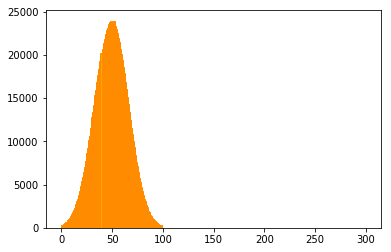

In [111]:
plt.bar(range(M), original, width=1., color='orange', edgecolor='darkorange')

### Plotting the reported data

In [58]:
total = np.zeros(M)
total[reported] = mod_coefs

Maybe, we don't want to report on estimates that are very low:

In [59]:
#total[total < 6000] = 0

<Container object of 300 artists>

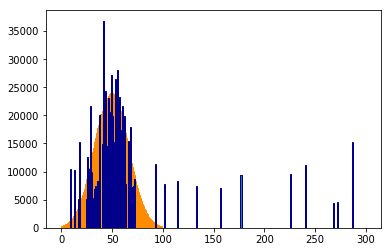

In [112]:
plt.bar(range(M), original, width=1., color='orange', edgecolor='darkorange')
plt.bar(range(M), total, width=1., edgecolor='darkblue')

## Measuring the quality of decoding

It would be nice to have an automatic way of judging how good the decoding worked.

A simple way to do this is to calculate the absolute distance between the actual and the reported distributions.
Finally, this measure is divided by the number of candidates.

In [113]:
def score(actual, reported):
    return np.sum(np.abs(actual - reported)) / len(actual)

In [114]:
score(org, coef_mean)

2313.8266666666668

## Measuring collisions

Some collisions are to be expected because of the Bloom filter. These are just some experiments for automatically calculating this.

In [115]:
counter = Counter([str(get_bloom_bits("v%d" % i , 0, h, k)) for i in range(100)])
counter

Counter({'[0, 0]': 3,
         '[0, 1]': 6,
         '[0, 2]': 7,
         '[0, 3]': 5,
         '[1, 0]': 9,
         '[1, 1]': 6,
         '[1, 2]': 7,
         '[1, 3]': 6,
         '[2, 0]': 2,
         '[2, 1]': 6,
         '[2, 2]': 10,
         '[2, 3]': 9,
         '[3, 0]': 3,
         '[3, 1]': 6,
         '[3, 2]': 4,
         '[3, 3]': 11})

In [116]:
from collections import defaultdict

counter = defaultdict(int)

for i in range(100):
    candidate = "v%d" % i
    hashed = []
    
    for cohort in range(m):
        hashed += get_bloom_bits("v%d" % i , cohort, h, k)
    
    counter[str(hashed)] += 1

In [117]:
len(counter.items())

100

## (Statistical Inference – Bonferroni)

In the Google repo, they calculate some more statistical properties. However, these values are not used for further filtering, they're just saved into variables.

**TODO**: We still have to figure out if we want to use techniques like these.

In [67]:
X[:, reported].shape

(128, 52)

In [68]:
y.shape

(128,)

In [69]:
def perform_inference(X, y, N, mod_coefs, mod_stds, alpha):
    pass

In the paper, $\alpha$ is set to $0.5$; in the code it's additionally divided by the total number of reports.

In [70]:
alpha = 0.05 / N_total

In [71]:
perform_inference(
    X[:, reported],
    y,
    N_total,
    mod_coefs,
    mod_stds,
    alpha
)

In [72]:
from sklearn.feature_selection import f_regression
from statsmodels.sandbox.stats.multicomp import multipletests

In [73]:
# F, ps = f_regression(X_good, y_good)
# ps_corrected = multipletests(ps, method='bonferroni')
# ps_corrected

In [74]:
# F.sort()
# F